In [141]:
import os
os.chdir('../quafing/')
print(f"Working directory: {os.getcwd()}")

import random
import numpy as np
import quafing as q
from scipy.stats import mode
from sklearn.feature_selection import mutual_info_regression

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from collections import Counter

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

Working directory: /Users/charlesdupont/Desktop/Thesis/code/quafing


In [2]:
def load_data(path):
    """
    Loads .dta file using provided path.
    """
    return pd.read_stata(path, convert_categoricals=False)


def add_missing_hhids(df):
    """
    Adds empty rows for hhids missing from df.
    df must already have an "hhid" column!
    """
    df = df.round({"hhid":1})
    missing = set(UNIQUE_HHID) - set(df["hhid"].unique())
    missing_dict = {"hhid":[round(item, 1) for item in list(missing)]}
    for col in df.columns:
        if col != "hhid":
            missing_dict[col] = [np.nan]*len(missing)
    missing_df = pd.DataFrame.from_dict(missing_dict)
    concat = pd.concat([df, missing_df])
    return concat.round({"hhid":1})


def column_selection(df, keep=None, remove=None):
    """
    Performs column selection on dataframe.
    Args:
        no_change: boolean indicating whether to keep all columns
        keep: list of columns to keep
        remove: list of columns to remove
    Returns:
        updated dataframe
    """
    if keep:
        return df[keep]
    elif remove:
        return df.loc[:, ~df.columns.isin(remove)]
    else:
        return df


def get_processed_df(results):
    processed = pd.DataFrame.from_dict({})
    for column in results[1]:
        processed[column] = [results[hhid][column] for hhid in results]
    return processed


def apply_mapping(df, mapping):
    results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
    for hhid in UNIQUE_HHID:
        household = df.loc[df.hhid==hhid]    
        for label, tup in mapping.items():
            col, operation = tup
            non_nan = household.loc[~household[col].isna()]
            results[hhid][label] = operation_lambda[operation](non_nan[col]) if len(non_nan) else np.nan
    return get_processed_df(results) 

In [3]:
DATA_DIR    = "../../BCCASII/"
DATA_SUBDIR = "Household/"

In [4]:
PROCESSED_DFS  = []
ADAPTATION_DFS = []

In [5]:
operation_lambda = {
    "sum": lambda x: x.sum(),
    "min": lambda x: x.min(),
    "max": lambda x: x.max(),
    "mean": lambda x: round(x.mean()),
    "mode": lambda x: x.mode()[0]
}

In [6]:
variable_types = {
    "discrete_categorical":set(),
    "discrete_ordered":set(),
    "continuous":set()
}

## A: Location and identification detail

In [8]:
filename = "001_mod_a.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [9]:
# keep household ID, agro-ecological zone
processed = column_selection(df, keep=["hhid", "ezcode"])

# construct community code from union, thana, district codes
processed["community_code"] = df["ucode"].astype(str) + "_" + \
                              df["tcode"].astype(str) + "_" + \
                              df["dcode"].astype(str)

UNIQUE_HHID = np.round(df["hhid"].unique().astype(np.float64), 1)
processed["hhid"] = processed["hhid"].astype(np.float64)

In [10]:
PROCESSED_DFS.append(processed)

In [11]:
for col in processed.columns:
    variable_types["discrete_categorical"].add(col)

## B: Household composition and education

In [12]:
filename = "002_mod_b.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [13]:
education_ordering = [99, 66, 67, 68, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 22, 10, 33, 12, 15, 16, 17]
literacy_ordering  = [1, 2, 3, 4]

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]    
    L = len(household)
    if L == 0:
        results[hhid] = {
            "hhid": hhid,
            "household_size": np.nan,
            "ratio_male": np.nan,
            "ratio_male_children": np.nan,
            "highest_education": np.nan,
            "highest_literacy": np.nan
        }
        continue

    # household size
    results[hhid]["household_size"] = L
    
    # ratio male
    m = sum(household["b01"]==1)
    results[hhid]["ratio_male"] = m/L

    # ratio of children that are male
    num_children = len(household.loc[household["b03"]<18])
    if num_children > 0:
        results[hhid]["ratio_male_children"] = len(household.loc[(household["b01"]==1) & \
                                                (household["b03"]<18)]) / num_children
    else:
        results[hhid]["ratio_male_children"] = 0
    
    # highest level of education
    education_levels = [education_ordering.index(x)
                        for x in [x for x in list(household["b06"]) if not np.isnan(x)]]
    results[hhid]["highest_education"] = max(education_levels) if len(education_levels) else np.nan
        
    # highest level of literacy
    literacy_labels = [literacy_ordering.index(x)
                       for x in [x for x in list(household["b05"]) if not np.isnan(x)]]
    results[hhid]["highest_literacy"] = max(literacy_labels) if len(literacy_labels) else np.nan

processed = get_processed_df(results)


# primary occupation categories
# categories = {
#     "day_labor": [1,2,3],
#     "self_employ_farm": [4,5,6,7,8],
#     "self_employ_non_farm": [9],
#     "low_income_profession": [10,11,12,13],
#     "mechanic": [14,15],
#     "other": [16, 17, 18, 19],
#     "non_earning": [20,21,22,23,24,25,26]
# }

# for c, c_list in categories.items():
#     c_dict = {hhid:0 for hhid in unique_hhids}
#     for hhid in unique_hhids:
#         household = df.loc[df.hhid==hhid]
#         primary_occupation_labels = list(household["b08_1"])
#         for item in c_list:
#             if item in primary_occupation_labels:
#                 c_dict[hhid] += 1
#     processed = processed.join(pd.DataFrame.from_dict({c:c_dict}))

In [14]:
PROCESSED_DFS.append(processed)

In [15]:
variable_types["discrete_categorical"].update({"highest_education"})
variable_types["discrete_ordered"].update({"highest_literacy", "household_size"})
variable_types["continuous"].update({"ratio_male", "ratio_male_children"})

## C: Roster of land and water bodies owned or under operation

In [16]:
filename = "003_mod_c.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [17]:
mapping = {
    "total_land_value_per_month": ("c113", "sum"),
    "plot_type": ("c101", "mode"),
    "soil_type": ("c105", "mode"),
    "land_operational_status": ("c107", "mode"),
    "land_acquisition_means": ("c110", "mode")
}

processed = apply_mapping(df, mapping)

In [18]:
PROCESSED_DFS.append(processed)

In [19]:
variable_types["discrete_categorical"].update({"plot_type", "soil_type", 
                                               "land_operational_status", "land_acquisition_means"})
variable_types["continuous"].update({"total_land_value_per_month"})

## F1: Livestock and poultry

In [20]:
filename = "004_mod_f1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [21]:
# # household id
# processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})

# categories = {
#     "cattle_buffalo":1,
#     "goat_sheep":2,
#     "pigs":3,
#     "chidken_duck":4
# }

# cols = [("count_2011", "f102"), ("value_2011", "f103"), 
#         ("count_now", "f104"), ("value_now", "f105"), ("total_selling_value", "f117")]   

# results = {hhid:{} for hhid in unique_hhids}
# for hhid in unique_hhids:
#     household = df.loc[df.hhid==hhid]
#     for c, number in categories.items():
#         if number not in list(household["f101"]):
#             # TODO: handle missing value!
#             for l, _ in cols:
#                 results[hhid][c+"_"+l] = np.nan
#         else:
#             for l, col in cols:
#                 value = household.loc[household["f101"]==number][col].iloc[0]
#                 # TODO: handle missing value here!
#                 if np.isnan(value):
#                     results[hhid][c+"_"+l] = np.nan
#                 else:
#                     results[hhid][c+"_"+l] = value
                    
# for column in results[1]:
#     processed[column] = [results[hhid][column] for hhid in results]

In [22]:
mapping = {
    "count_2011": ("f102", "sum"),
    "value_2011": ("f103", "sum"),
    "count_now": ("f104", "sum"),
    "value_now": ("f105", "sum"),
    "total_selling_value": ("f117", "sum"),
}

processed = apply_mapping(df, mapping)

In [23]:
PROCESSED_DFS.append(processed)

In [24]:
variable_types["discrete_ordered"].update({"count_2011", "count_now"})
variable_types["continuous"].update({"value_2011", "value_now", "total_selling_value"})

## F3: Expenditure for livestock, Poultry/Duckery Production Last 12 Months

In [25]:
filename = "005_mod_f3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [26]:
mapping = {
    "livestock_fodder_value": ("f302", "sum"),
    "livestock_medication_value": ("f303", "sum"),
    "livestock_hired_male_labor": ("f306_1", "sum"),
}

processed = apply_mapping(df, mapping)

In [27]:
PROCESSED_DFS.append(processed)

In [28]:
variable_types["continuous"].update({"livestock_fodder_value", "livestock_medication_value", 
                                     "livestock_hired_male_labor"})

## G1, G2: Credit

In [29]:
filename = "006_mod_g.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [30]:
loan_categories = {
    "credit_personal_capital":[1,2,3,7,8,9,10,11,12,15,17,18],
    "credit_natural_capital":[4,5,6,13,14,16]
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    for label, numbers in loan_categories.items():
        rows = household.loc[household["g02"].isin(numbers)]
        cash_borrowed = [x for x in list(rows["g07"]) if not np.isnan(x)]
        value_borrowed = [x for x in list(rows["g10"]) if not np.isnan(x)]
        borrowed_combined = cash_borrowed + value_borrowed
        results[hhid][label+"_total_borrowed"] = sum(borrowed_combined) if len(borrowed_combined) else np.nan
        
        cash_remaining = [x for x in list(rows["g23"]) if not np.isnan(x)]
        value_remaining = [x for x in list(rows["g25"]) if not np.isnan(x)]
        remaining_combined = cash_remaining + value_remaining
        results[hhid][label+"_total_to_pay"] = sum(remaining_combined) if len(remaining_combined) else np.nan
        
processed = get_processed_df(results)

In [31]:
PROCESSED_DFS.append(processed)

In [32]:
variable_types["continuous"].update({"credit_personal_capital_total_borrowed", 
                                     "credit_personal_capital_total_to_pay", 
                                     "credit_natural_capital_total_borrowed",
                                     "credit_natural_capital_total_to_pay"})

Counter({'soil_type': 1,
         'community_code': 1,
         'land_acquisition_means': 1,
         'hhid': 1,
         'land_operational_status': 1,
         'ezcode': 1,
         'highest_education': 1,
         'plot_type': 1,
         'count_2011': 1,
         'household_size': 1,
         'highest_literacy': 1,
         'count_now': 1,
         'value_2011': 1,
         'ratio_male': 1,
         'credit_natural_capital_total_to_pay': 1,
         'livestock_hired_male_labor': 1,
         'credit_personal_capital_total_to_pay': 1,
         'livestock_medication_value': 1,
         'credit_natural_capital_total_borrowed': 1,
         'ratio_male_children': 1,
         'total_land_value_per_month': 1,
         'value_now': 1,
         'credit_personal_capital_total_borrowed': 1,
         'livestock_fodder_value': 1,
         'total_selling_value': 1})

## H: Household Assets

In [34]:
filename = "007_mod_h.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [35]:
# total value per household asset category
categories = {
    "value_consumable_durables":[i for i in range(1, 12)],
    "value_transport":[i for i in range(12, 16)],
    "value_livestock_poultry":[i for i in range(16, 20)],
    "value_agricultural_equipments":[i for i in range(20,29)],
    "value_other":[29]
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    for c in categories:
        category_assets = household.loc[household["asset"].isin(categories[c])]
        results[hhid][c] = category_assets["h06"].sum() if len(category_assets) else np.nan

processed = get_processed_df(results)

In [36]:
PROCESSED_DFS.append(processed)

In [37]:
variable_types["continuous"].update({"value_consumable_durables", 
                                     "value_transport", 
                                     "value_livestock_poultry",
                                     "value_agricultural_equipments", 
                                     "value_other"})

In [39]:
asdf = []
for t, cols in variable_types.items():
    for c in cols:
        asdf.append(c)
        
asdf = Counter(asdf)
print(2 in asdf.values())

False


## H1: Assets: Sales of Assets and Change in Ownership

In [40]:
filename = "008_mod_h1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [41]:
mapping = {"sale_of_assets_value": ("h108", "sum")}
processed = apply_mapping(df, mapping)

In [42]:
PROCESSED_DFS.append(processed)

In [43]:
variable_types["continuous"].update({"sale_of_assets_value"})

## I: Food Consumption: Purchases, Home Production, and Other Sources

In [44]:
filename = "009_mod_i.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [45]:
food_categories = {
    "food_cereals":np.arange(1,10),
    "food_pulses":np.arange(11,18),
    "food_edible_oil":np.arange(21,25),
    "food_vegetables":np.arange(31,56),
    "food_leafy_vegetables":np.arange(61,75),
    "food_meat_eggs_milk":np.arange(81,88),
    "food_fruits":np.arange(91,113),
    "food_fish_large":np.arange(121,132),
    "food_fish_small":np.arange(141,149),
    "food_spices":np.arange(151,161),
    "food_other":np.arange(171,177),
    "food_drinks":np.arange(181,184),
    "food_other_outside_home":np.arange(201,213)
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    for c, fcodes in food_categories.items():
        relevant_rows = household.loc[household["fcode"].isin(fcodes)]
        for (col, label) in [("i07", "value_"), ("i04", "weight_")]:
            non_nan = relevant_rows.loc[~relevant_rows[col].isna()]
            results[hhid][label+c] = non_nan[col].sum() if len(non_nan) else np.nan
            
processed = get_processed_df(results)

In [46]:
PROCESSED_DFS.append(processed)

In [47]:
update_set = set()
for col in processed.columns:
    update_set.add(col)
variable_types["continuous"].update(update_set)

## J1, J2: Non-food Expenditure

In [52]:
filename = "010_mod_j.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [53]:
non_food_categories = {
    "rent_bills_taxes_fees_expenses":[1,2,49,50,51,52,53],
    "fuel_expenses":[3,4,5,6],
    "transportation_vehicles_expenses":[7,8,27,28,73,74,75,76],
    "miscellaneous_expenses":[9,10,11,12,13,29,30,31,32,54,55],
    "health_expenses":[14,15,16],
    "communication_expenses":[17,18],
    "personal_items_clothing_expenses":[19,20,21,22,23,24,33,34,35,36,37,38],
    "entertainment_expenses":[25,26],
    "furniture_household_expenses":np.arange(39,49),
    "family_events_expenses":[56,57,58,59,60,61,62,63,64,65,66],
    "education_expenses":np.arange(67,73),
}

sources = [(1, "social"), (2, "self"), (3, "other")]

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    for c, nfcodes in non_food_categories.items():
        relevant_rows = household.loc[household["nfcode"].isin(nfcodes)]
        
        # total cash expenditure for last 1 month, last 12 months
        for col in ["j02_1", "j02_2"]:
            non_nan = relevant_rows.loc[~relevant_rows[col].isna()]
            results[hhid][col+"_"+c] = non_nan[col].sum() if len(non_nan) else np.nan
        
        # imputed expenditure, last 1 month, last 12 months, for each possible source
        for col1, col2 in [("j03_1", "j04_1"), ("j03_2", "j04_2")]:
            for code, source_label in sources:
                non_nan = relevant_rows.loc[(~relevant_rows[col1].isna()) & (relevant_rows[col2]==code)]
                results[hhid][col1+"_"+c+"_"+source_label] = non_nan[col1].sum() if len(non_nan) else np.nan

processed = get_processed_df(results)

In [54]:
PROCESSED_DFS.append(processed)

In [55]:
update_set = set()
for col in processed.columns:
    update_set.add(col)
variable_types["continuous"].update(update_set)

## K: Housing, Source of Water and sanitation

In [57]:
filename = "011_mod_k.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [58]:
processed = column_selection(df, keep=["hhid", "k01", "k02", "k03", "k03_1",
                                       "k04", "k05", "k05_1", "k06", "k07"])

In [59]:
PROCESSED_DFS.append(processed)

In [60]:
variable_types["discrete_ordered"].add("k01")
variable_types["discrete_categorical"].update({"k02", "k03", "k03_1",
                                               "k04", "k05", "k05_1", 
                                               "k06", "k07"})

## L, L1: Weather events adversely affected the household or the farming cope

In [62]:
filename = "013_mod_l1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [63]:
calamity_numbers = [i for i in range(1, 13)]
action_taken_categories = {
    "sold": ([2,3,4,5],1),
    "borrowed": ([6,7,8],2),
    "migrated": ([11,12,13],3),
    "off_farm_employment":([14],4),
    "nothing":([1],5),
    "food_work_aid":([9,10],6)
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid == hhid]
    for n in calamity_numbers:
        label = f"calamity_{n}_"
        relevant_rows = household.loc[household["l1_01"]==n]
        total_loss = sum([x for x in relevant_rows["l1_05"] if not np.isnan(x)])
        results[hhid][label+"loss"] = total_loss if len(relevant_rows) else np.nan
        action_taken_label = label+"action_taken"
        results[hhid][action_taken_label] = np.nan
        for action_label, tup in action_taken_categories.items():
            nums, idx = tup
            action_taken = [x for x in relevant_rows["l1_02"] if x in nums]
            if action_taken: 
                results[hhid][action_taken_label] = idx
                break
            
processed = get_processed_df(results)

In [64]:
PROCESSED_DFS.append(processed)

In [65]:
for col in processed.columns:
    if "loss" in col:
        variable_types["continuous"].add(col)
    elif "action_taken" in col:
        variable_types["discrete_categorical"].add(col)

## L2: Shocks

In [67]:
filename = "014_mod_l2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

mapping   = {"shocks_loss_value": ("l2_06", "sum")}
processed = apply_mapping(df, mapping)
PROCESSED_DFS.append(processed)

In [68]:
variable_types["continuous"].add("shocks_loss_value")

## L3: Positive Economic Events

In [70]:
filename = "015_mod_l3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

mapping   = {"positive_events_value": ("l3_06", "sum")}
processed = apply_mapping(df, mapping)
PROCESSED_DFS.append(processed)

In [71]:
variable_types["continuous"].add("positive_events_value")

## M: Agricultural extension

In [73]:
filename = "017_mod_m.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

PROCESSED_DFS.append(df)

In [74]:
for col in df.columns:
    if col == "m03":
        variable_types["discrete_ordered"].add(col)
    else:
         variable_types["discrete_categorical"].add(col)

## Q: Perceptions of Climate Change

In [76]:
filename = "018_mod_q.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

PROCESSED_DFS.append(df)

In [77]:
for col in df.columns:
    variable_types["discrete_categorical"].add(col)

## O: Changes in farming practices due to climate change

In [79]:
filename = "019_mod_o.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [80]:
keep = ["hhid", "o01"] + ["o0"+str(i)+"_1" for i in range(2, 9)] + ["o09"] + \
       ["o"+str(i) for i in range(10, 23)] + ["o"+str(i)+"_1" for i in range(23, 29)] + ["o29"]

processed = column_selection(df, keep=keep)

change_categories = {
    "change_production_methods": ["o02_1", "o03_1", "o07_1", "o08_1", "o18", "o19"],
    "change_crop_consumption": ["o06_1"],
    "change_land": ["o04_1", "o05_1", "o09", "o13", "o14", "o15", "o16"],
    "change_water_harvesting": ["o10", "o11", "o12"],
    "change_insurance": ["o17"],
    "change_off_farm_employment": ["o20"],
    "change_migration": ["o21"],
    "change_communal_storage": ["o22"],
    "change_planting_dates":["o23_1", "o24_1", "o25_1"],
    "change_fertilizer":["o26_1", "o27_1", "o28_1"],
    "change_other":["o29"]
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = processed.loc[processed.hhid==hhid]
    
    # there is an entry for the household, and they haven't made any changes
    if len(household) and household["o01"].iloc[0] == 2:
        for category in change_categories:
            results[hhid][category] = 0
        continue
        
    # no entry for household
    elif not len(household):
        for category in change_categories:
            results[hhid][category] = np.nan
        continue
    
    for category, cols in change_categories.items():
        row = household[cols]
        if len(row):
            bools = [x for x in row.iloc[0] if not np.isnan(x)]
            results[hhid][category] = int(1 in bools) if len(bools) else np.nan
                
processed = get_processed_df(results)

In [81]:
PROCESSED_DFS.append(processed)
ADAPTATION_DFS.append(processed)

In [82]:
for col in processed.columns:
    variable_types["discrete_categorical"].add(col)

## O1: Any integration about Livestock/Poultry

In [84]:
filename = "020_mod_o1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [85]:
keep = ["hhid"] + ["o1_01_"+str(i) for i in range(1, 10)]
processed = column_selection(df, keep=keep)
processed["livestock_poultry_change"] = ((processed[["o1_01_"+str(i) for i in range(1, 10)]]==1) \
                                         .sum(axis=1) > 0).astype("int")
processed = column_selection(processed, keep=["hhid", "livestock_poultry_change"])

In [86]:
PROCESSED_DFS.append(processed)
ADAPTATION_DFS.append(processed)

In [87]:
variable_types["discrete_categorical"].add("livestock_poultry_change")

## O2: Constraints to adaptation

In [89]:
filename = "021_mod_o2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [90]:
constraint_codes = np.arange(1,10)

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    for _, row in household.iterrows():
        severity    = [x for x in row[["o2_03_1", "o2_03_2", "o2_03_3", "o2_03_4", "o2_03_5"]]]
        constraints = [x for x in row[["o2_02_1", "o2_02_2", "o2_02_3", "o2_02_4", "o2_02_5"]]]
        for i in range(len(constraints)):
            c = constraints[i]
            s = severity[i]            
            if np.isnan(c) or np.isnan(s):
                continue
            c = int(c)
            label = f"constraint_{c}_total_severity"
            if label not in results[hhid]:
                results[hhid][label] = [s]
            else:
                results[hhid][label].append(s)
                
    for code in constraint_codes:
        label = f"constraint_{code}_total_severity"
        if label not in results[hhid]:
            results[hhid][label] = np.nan
        else:
            results[hhid][label] = np.mean(results[hhid][label])
        
processed = get_processed_df(results)

In [91]:
PROCESSED_DFS.append(processed)

In [92]:
for col in processed.columns:
    variable_types["continuous"].add(col)

## R1: Information of group based approach

In [94]:
filename = "022_mod_r1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [95]:
group_categories = {
    "group_membership_farming":[1, 13],
    "group_membership_trading":[2],
    "group_membership_religion":[3],
    "group_membership_women":[4],
    "group_membership_NGO":[5,11,15],
    "group_membership_credit":[6],
    "group_membership_community":[7,16,17],
    "group_membership_cultural":[8,10],
    "group_membership_political":[9],
    "group_membership_health":[12],
    "group_membership_sports":[14],
    "group_membership_other":[18]
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    
    # there is an entry for the household, and nobody belongs to a group
    if len(household) == 1 and household["r01"].iloc[0] == 2:
        for categ in group_categories:
            results[hhid][categ] = 0
        continue
    
    # no entry for household
    elif not len(household):
        for categ in group_categories:
            results[hhid][categ] = np.nan
        continue
        
    for categ, codes in group_categories.items():
        # get rows matching the group codes    
        rows = household.loc[household["r1_01"].isin(codes)]
        # (TODO) assume no membership if group codes do not appear at all
        if not len(rows):
            results[hhid][categ] = 0
        else:
            membership = [x for x in list(rows["r1_02"]) if not np.isnan(x)]
            results[hhid][categ] = int(1 in membership) if len(membership) else np.nan
            
processed = get_processed_df(results)

In [96]:
PROCESSED_DFS.append(processed)

In [97]:
for col in processed.columns:
    variable_types["discrete_categorical"].add(col)

## R2: Group activity related information

In [99]:
filename = "023_mod_r2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [100]:
# a few duplicate rows found in this data file...
duplicates = []
for hhid in df["hhid"].unique():
    if len(df.loc[df.hhid==hhid]) > 1:
        duplicates.append(hhid)
    
drop_indices = []
for d in duplicates:
    drop_indices.append(list(df.loc[df.hhid==d].index)[0])

df = df.drop(drop_indices)

In [101]:
keep = ["hhid"] + [f"r2_15_{i}" for i in range(1,5)] + [f"r2_16_{i}" for i in range(1,5)]
for j in range(17, 24):
    keep += [f"r2_{j}_{i}_1" for i in range(1,5)]
    
processed = column_selection(df, keep=keep)
PROCESSED_DFS.append(processed)

In [102]:
for col in processed.columns:
    variable_types["discrete_categorical"].add(col)

## R3: Network

In [104]:
filename = "024_mod_r3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [105]:
processed = column_selection(df, remove=["r3_01_1", "r3_01_2"])

In [106]:
PROCESSED_DFS.append(processed)

In [107]:
variable_types["discrete_ordered"].update({"r3_02_1", "r3_02_2", 
                                           "r3_03_1", "r3_03_2",
                                           "r3_04_1", "r3_04_2",
                                           "r3_07_1", "r3_07_2",
                                           "r3_06_1", "r3_06_2"})

variable_types["discrete_categorical"].update({"r3_05_1", "r3_05_2"})

## R4: Trust and Solidarity

In [110]:
filename = "025_mod_r4.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [111]:
processed = column_selection(df, remove=["r4_01_1", "r4_01_2"])

In [112]:
PROCESSED_DFS.append(processed)

In [113]:
for col in processed.columns:
    if "r4_04" in col or "r4_03" in col:
        variable_types["discrete_ordered"].add(col)
    else:
        variable_types["discrete_categorical"].add(col)

## R5: Economic setbacks

In [115]:
# filename = "026_mod_r5.dta"
# path = DATA_DIR + DATA_SUBDIR + filename
# df = load_data(path)
# results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
# for hhid in UNIQUE_HHID:
#     household = df.loc[df.hhid==hhid]
#     results[hhid]["serious_economic_setback"] = 1 if 1 in list(household["r5"]) else 0
# processed = get_processed_df(results)
# PROCESSED_DFS.append(processed)

## R6: Collective Action and Cooperation and Sociability

In [116]:
filename = "027_mod_r6.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [117]:
processed = column_selection(df, remove=["r6_01_1", "r6_01_2"])

In [118]:
PROCESSED_DFS.append(processed)

In [119]:
for col in processed.columns:
    if "r6_05" in col or "r6_06" in col or "r6_07" in col or "r6_08" in col:
        variable_types["discrete_ordered"].add(col)
    else:
        variable_types["discrete_categorical"].add(col)

## R7: Information and Communication

In [120]:
filename = "028_mod_r7.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [121]:
PROCESSED_DFS.append(df)

In [122]:
for col in df.columns:
    if "r7_01" in col or "r7_02" in col or "r7_03" in col or "r7_04" in col or "r7_05" in col or "r7_08" in col:
        variable_types["discrete_ordered"].add(col)
    else:
        variable_types["discrete_categorical"].add(col)

## R8: Production and climate Information

In [123]:
# filename = "029_mod_r8.dta"
# path = DATA_DIR + DATA_SUBDIR + filename
# df = load_data(path)
# keep = ["hhid", "r8_02_1", "r8_02_2", "r8_06_1", "r8_06_2", "r8_14_1", "r8_14_2"]
# processed = column_selection(df, keep=keep)
# PROCESSED_DFS.append(processed)

## R9: Production and climate Information

In [124]:
# filename = "030_mod_r9.dta"
# path = DATA_DIR + DATA_SUBDIR + filename
# df = load_data(path)
# keep = ["hhid", "r9_02_1", "r9_02_2", "r9_09_1", "r9_09_2"]
# processed = column_selection(df, keep=keep)
# PROCESSED_DFS.append(processed)

## S: Empowerment and Political Action

In [125]:
filename = "031_mod_s.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [126]:
processed = column_selection(df, remove=["s_01_1", "s_01_2"])

In [127]:
PROCESSED_DFS.append(processed)

In [128]:
for col in processed.columns:
    if "s_02" in col or "s_03" in col or "s_04" in col or "s_05" in col or "s_09" in col:
        variable_types["discrete_ordered"].add(col)
    else:
        variable_types["discrete_categorical"].add(col)

## T: Employment

In [130]:
filename = "032_mod_t.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [131]:
job_categories = {
    "job_wage_labor":np.arange(1,12),
    "job_salaried_worker":np.arange(12,22),
    "job_self_employment":np.arange(22,48),
    "job_trader":np.arange(50,55),
    "job_production":np.arange(55,58),
    "job_livestock_poultry_service":np.arange(58,64),
    "job_farming":np.arange(64,73)
}

results = {hhid:{"hhid":hhid} for hhid in UNIQUE_HHID}
for hhid in UNIQUE_HHID:
    household = df.loc[df.hhid==hhid]
    relevant = list(household["t05"])
    for c, numbers in job_categories.items():
        results[hhid][c] = 0
        for n in numbers:
            if n in relevant:
                results[hhid][c] += 1
    monthly_incomes = [x for x in household["t14"] if not np.isnan(x)]
    results[hhid]["avergage_monthly_income"] = sum(monthly_incomes) if len(monthly_incomes) else np.nan
            
processed = get_processed_df(results)

In [132]:
PROCESSED_DFS.append(processed)

In [133]:
for col in processed.columns:
    if "job_" in col:
        variable_types["discrete_categorical"].add(col)
    else:
        variable_types["continuous"].add(col)

## U: Time use of male and female members in the household

In [135]:
# discard

## V: Anthropometry

In [136]:
# discard

# Combine processed dataframes

In [137]:
# mind the treatment of MISSING VALUES!
    # do we really want to impute "0" when no information is present?
    # just leave as empty
        # then if we see a household with many empty fields, or a feature with mostly empty values,
        # we remove it

In [138]:
# add missing household ids
all_hhids_present = []
for idx, df in enumerate(PROCESSED_DFS):
    df["hhid"] = np.round(df["hhid"].astype(np.float64), 1)
    if len(df["hhid"].unique()) != len(UNIQUE_HHID):
        all_hhids_present.append(add_missing_hhids(df))
    else:
        all_hhids_present.append(df)

# sanity check
for df in all_hhids_present:
    hids = df["hhid"].unique()
    for h in hids:
        assert h in UNIQUE_HHID
    for h in UNIQUE_HHID:
        assert h in hids
        
# merge all dataframes
df = all_hhids_present[0]
for df1 in all_hhids_present[1:]:
    df = df.merge(df1, on="hhid", how="inner")
assert df.shape[0] == len(UNIQUE_HHID)

In [139]:
df.to_csv(DATA_DIR + DATA_SUBDIR + "combined.csv")
df

,hhid,ezcode,community_code,household_size,ratio_male,ratio_male_children,highest_education,highest_literacy,total_land_value_per_month,plot_type,...,s_08_2,s_09_2,job_wage_labor,job_salaried_worker,job_self_employment,job_trader,job_production,job_livestock_poultry_service,job_farming,avergage_monthly_income
0,1.0,7,1_1_1,9.0,0.555556,0.333333,20.0,3.0,50.0,2.0,...,1.0,2.0,0,1,1,0,0,0,3,8650.0
1,2.0,7,1_1_1,6.0,0.500000,0.000000,8.0,3.0,500.0,2.0,...,1.0,3.0,1,0,0,0,0,0,3,4090.0
2,3.0,7,1_1_1,4.0,0.750000,1.000000,18.0,3.0,NaN,2.0,...,1.0,3.0,0,0,1,0,0,0,3,5650.0
3,4.0,7,1_1_1,6.0,0.333333,0.000000,8.0,3.0,384.0,2.0,...,1.0,3.0,0,0,0,0,0,0,4,18700.0
4,5.0,7,1_1_1,7.0,0.428571,1.000000,15.0,3.0,NaN,2.0,...,1.0,3.0,0,0,1,0,0,0,2,10300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,796.0,6,40_39_31,10.0,0.400000,0.500000,12.0,3.0,NaN,2.0,...,1.0,3.0,0,0,1,0,0,0,3,20563.0
823,797.0,6,40_39_31,9.0,0.333333,0.250000,13.0,3.0,510.0,2.0,...,2.0,2.0,1,0,0,0,0,0,4,4800.0
824,798.0,6,40_39_31,7.0,0.571429,0.000000,9.0,3.0,NaN,2.0,...,1.0,2.0,0,0,0,0,0,0,2,3530.0
825,799.0,6,40_39_31,9.0,0.555556,0.250000,17.0,3.0,NaN,2.0,...,1.0,2.0,0,0,0,0,0,0,3,1200.0


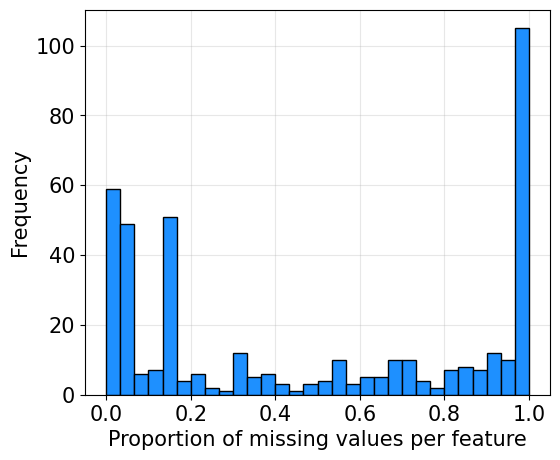

In [142]:
col_nan_counts = {}
L = len(df)
for col in df.columns:
    col_nan_counts[col] = (df[col].isna().sum()) / L

plt.hist(col_nan_counts.values(), color="dodgerblue", edgecolor="k", bins=30)
plt.xlabel("Proportion of missing values per feature")
plt.ylabel("Frequency")
plt.show()

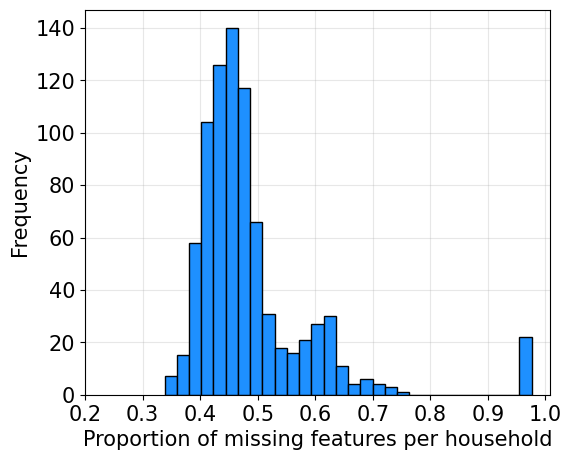

In [143]:
row_nan_counts = {}
num_cols = len(df.columns)
for i in range(len(df)):
    row = df.loc[[i]]
    hhid = list(row["hhid"])[0]
    row_nan_counts[hhid] = (row.isna().sum().sum()) / num_cols

plt.hist(row_nan_counts.values(), color="dodgerblue", edgecolor="k", bins=30)
plt.xticks(np.linspace(0.2, 1.0, 9))
plt.xlabel("Proportion of missing features per household")
plt.ylabel("Frequency")
plt.show()

In [144]:
# sanity check for variable types
for col in df.columns:
    if not (col in variable_types["discrete_ordered"] or 
            col in variable_types["discrete_categorical"] or
            col in variable_types["continuous"]):
        print(col)
        
for t, cols in variable_types.items():
    for c in cols:
        if c not in df.columns:
            print(c)

variable_types["discrete_ordered"].discard("hhid")
variable_types["continuous"].discard("hhid")

In [160]:
counts = []
for t, cols in variable_types.items():
    for c in cols:
        counts.append(c)
        
counts = Counter(counts)
if 2 in counts.values():
    print("Counting error!")
assert len(counts) == len(df.columns)

# Mutual Information Regression

In [219]:
# compute number of changes implemented by each household
num_changes = {hhid:0 for hhid in UNIQUE_HHID}
for DF in ADAPTATION_DFS:
    for hhid in UNIQUE_HHID:
        hh = DF.loc[DF.hhid==hhid]
        if len(hh):
            ignore_hhid_col = hh.loc[:, ~hh.columns.isin(['hhid'])]
            num_changes[hhid] += sum(np.array(ignore_hhid_col.iloc[0]==1))

### With NaN filling

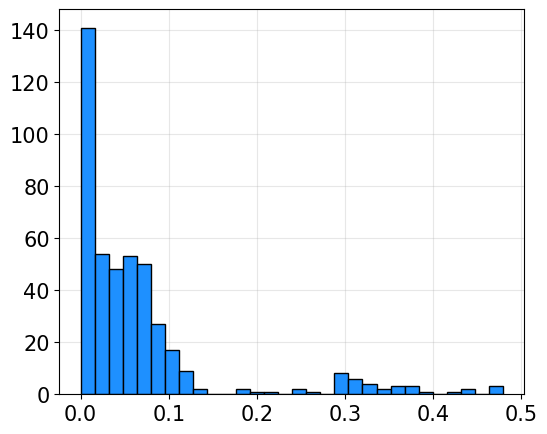

In [220]:
adaptation_target = np.array(list(num_changes.values()))
features = column_selection(df, remove=["hhid", "community_code"]).fillna(-1) # replace nan with -1
mutual_information_scores = mutual_info_regression(features, adaptation_target, 
                                                   discrete_features="auto") # TODO: pass array for discreteness

plt.hist(mutual_information_scores, color="dodgerblue", edgecolor="k", bins=30)
plt.show()

In [221]:
feature_cols = list(features.columns)
d = {feature_cols[i]:mutual_information_scores[i] for i in range(len(feature_cols))}

ordered = sorted([(k,v) for (k,v) in d.items()], key = lambda x: d[x[0]], reverse=True)
ordered_no_target = [item for item in ordered if item[0][0] != "o"]
ordered_no_target

[('constraints_0_measure', 0.39234847596922817),
 ('constraints_1_measure', 0.36853737343821225),
 ('constraints_0_constraint', 0.32058561860297896),
 ('constraints_1_constraint', 0.3080571952654303),
 ('constraints_2_measure', 0.29782633720301943),
 ('constraints_3_measure', 0.266331288285262),
 ('constraints_3_constraint', 0.2454091388110271),
 ('constraints_2_constraint', 0.24355883612697804),
 ('m01', 0.14373220437827605),
 ('constraints_4_measure', 0.13864792807058102),
 ('m07', 0.12579682932278358),
 ('constraints_4_constraint', 0.11925723627805018),
 ('r2_23_1_1', 0.11870037413922807),
 ('r7_05_1', 0.1152410933523993),
 ('r2_19_1_1', 0.11374209780287314),
 ('r2_20_1_1', 0.11229289643311446),
 ('q01_1', 0.11203428443851493),
 ('job_farming', 0.11201958095322428),
 ('r2_22_1_1', 0.1078409918755221),
 ('ezcode', 0.10745105886660422),
 ('q07_1', 0.10677899517784839),
 ('r2_16_1', 0.10535984949667032),
 ('q04', 0.10221914999656478),
 ('k07', 0.1016104616127147),
 ('q03', 0.1013665934

### Without NaN filling

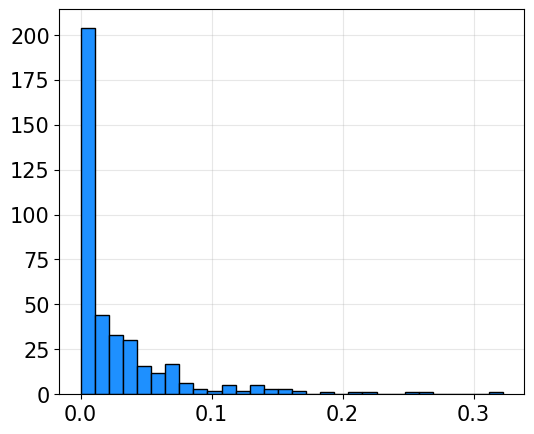

In [251]:
mi_scores = {}
for col in df.columns:
    if col not in ["hhid", "community_code"]:
        non_nan_rows = df.loc[~df[col].isna()]
        if len(non_nan_rows) < 5:
            continue
        indices = np.array(non_nan_rows.index)
        targets = adaptation_target[indices]
        mi_scores[col] = mutual_info_regression(np.array(list(non_nan_rows[col])).reshape(-1,1), targets)[0]
        
plt.hist(mi_scores.values(), color="dodgerblue", edgecolor="k", bins=30)
plt.show()

In [252]:
ordered = sorted([(k,v) for (k,v) in mi_scores.items()], key = lambda x: mi_scores[x[0]], reverse=True)
ordered_no_target = [item for item in ordered if item[0][0] != "o"]
ordered_no_target

[('constraints_0_measure', 0.3227410581457395),
 ('j03_2_miscellaneous_expenses', 0.26760704895379805),
 ('r6_04_2_2', 0.25503878319387185),
 ('j02_1_vehicle_expenses', 0.21901586068252743),
 ('r6_03_1_3', 0.161238297063393),
 ('constraints_1_measure', 0.15756197334061683),
 ('constraints_6_constraint', 0.1426777786159914),
 ('constraints_5_measure', 0.1402324670511681),
 ('r7_06_2_3', 0.1346352794665875),
 ('constraints_2_measure', 0.13439313565208755),
 ('j03_2_family_events_expenses', 0.13055555555555576),
 ('r7_11_1_2', 0.12997153997761135),
 ('r6_04_2_1', 0.119134908690123),
 ('r6_03_1_2', 0.11566389117930065),
 ('r7_07_2_3', 0.11360038236625414),
 ('constraints_6_measure', 0.10988919824367871),
 ('constraints_3_measure', 0.10597062277959735),
 ('m02_2', 0.09648391651305177),
 ('q01_2', 0.09403777248097578),
 ('weight_food_drinks', 0.08653058078690234),
 ('weight_food_fish_large', 0.08570147348820356),
 ('j03_1_personal_items_expenses', 0.08222865125300771),
 ('r2_23_4_1', 0.07812